In [344]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
solar_flare = fetch_ucirepo(id=89) 
  
# data (as pandas dataframes) 
X = solar_flare.data.features 
feature_names = X.columns.tolist()
# X = X.drop(columns=['modified Zurich class'])

# metadata 
print(solar_flare.metadata) 
  
# variable information 
print(solar_flare.variables) 


{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

In [345]:
import numpy as np
import torch

In [346]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for both categorical columns
le_largest_spot = LabelEncoder()
le_spot_distribution = LabelEncoder()
le_modified_zurich_class = LabelEncoder()

# Fit and transform the categorical columns
X['largest spot size'] = le_largest_spot.fit_transform(X['largest spot size'])
X['spot distribution'] = le_spot_distribution.fit_transform(X['spot distribution'])
X['modified Zurich class'] = le_spot_distribution.fit_transform(X['modified Zurich class'])

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_spars

In [348]:
X

,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot
0,1,4,2,1,2,1,1,2,1,2
1,2,4,2,1,3,1,1,2,1,2
2,1,4,2,1,3,1,1,2,1,1
3,2,4,2,1,3,1,1,2,1,2
4,2,0,2,1,3,1,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...
1384,5,4,3,1,2,1,1,1,1,1
1385,5,4,3,2,2,1,1,2,1,1
1386,1,4,2,1,2,1,2,2,1,1
1387,5,3,3,1,2,1,1,2,1,1


In [351]:
grouped_data = []

for _, group in X.groupby('modified Zurich class'):
    group_data = group.drop(columns=['modified Zurich class']).to_numpy()
    grouped_data.append(group_data)

In [352]:
datasets = grouped_data

In [353]:
len(datasets)

6

In [354]:
feature_names.remove("modified Zurich class")

In [355]:
feature_names

['largest spot size',
 'spot distribution',
 'activity',
 'evolution',
 'previous 24 hour flare activity',
 'historically-complex',
 'became complex on this pass',
 'area',
 'area of largest spot']

In [366]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
classifier = OneClassSMMClassifier(nu=0.3)
classifier.fit(datasets)

nu is set to 0.34 since we want 2 outliers out of 6 which is 33.33 percent

In [367]:
decision, y_pred = classifier.predict(datasets)

In [368]:
decision


array([-1.93610641e-07,  5.98616283e-02,  8.17758925e-02,  2.18487427e-02,
       -7.57236033e-07, -2.38910930e-07])

In [369]:
y_pred

array([-1.,  1.,  1.,  1., -1., -1.])

In [370]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[0, 4, 5]

In [331]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

divide by zero encountered in log2
invalid value encountered in cast
invalid value encountered in log2
  0%|          | 0/511 [00:00<?, ?it/s]

100%|██████████| 511/511 [01:13<00:00,  6.96it/s]


In [110]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

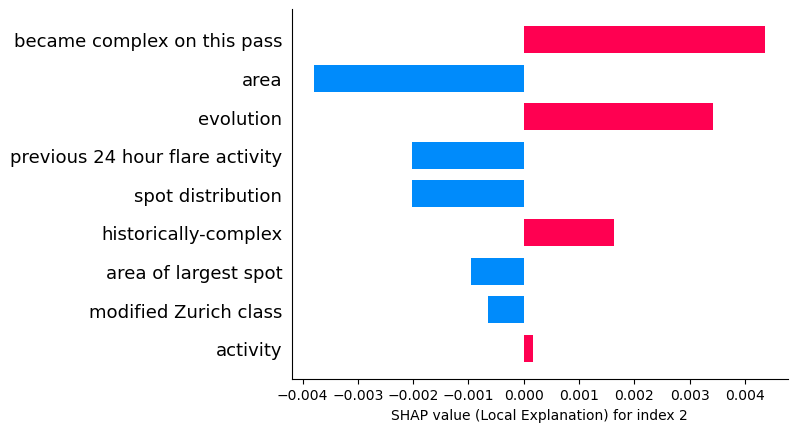

In [111]:
from src.utils.visualisation.deterministic_values import global_bar_plot, local_bar_plot
local_bar_plot(shapley_values, 2,  feature_names=feature_names)

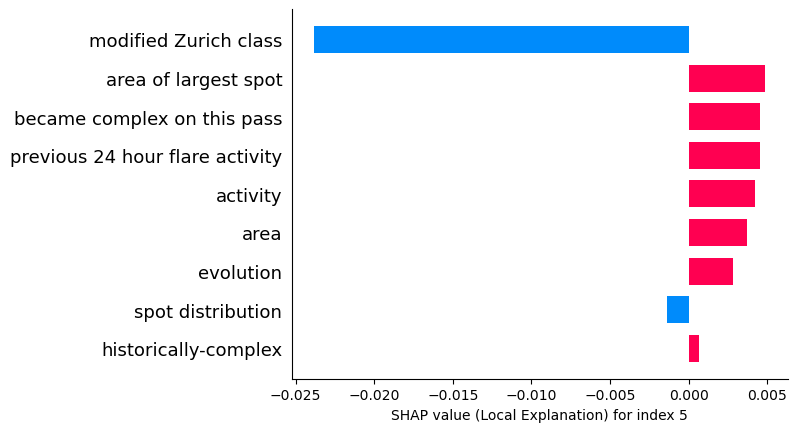

In [112]:
local_bar_plot(shapley_values, 5,  feature_names=feature_names)

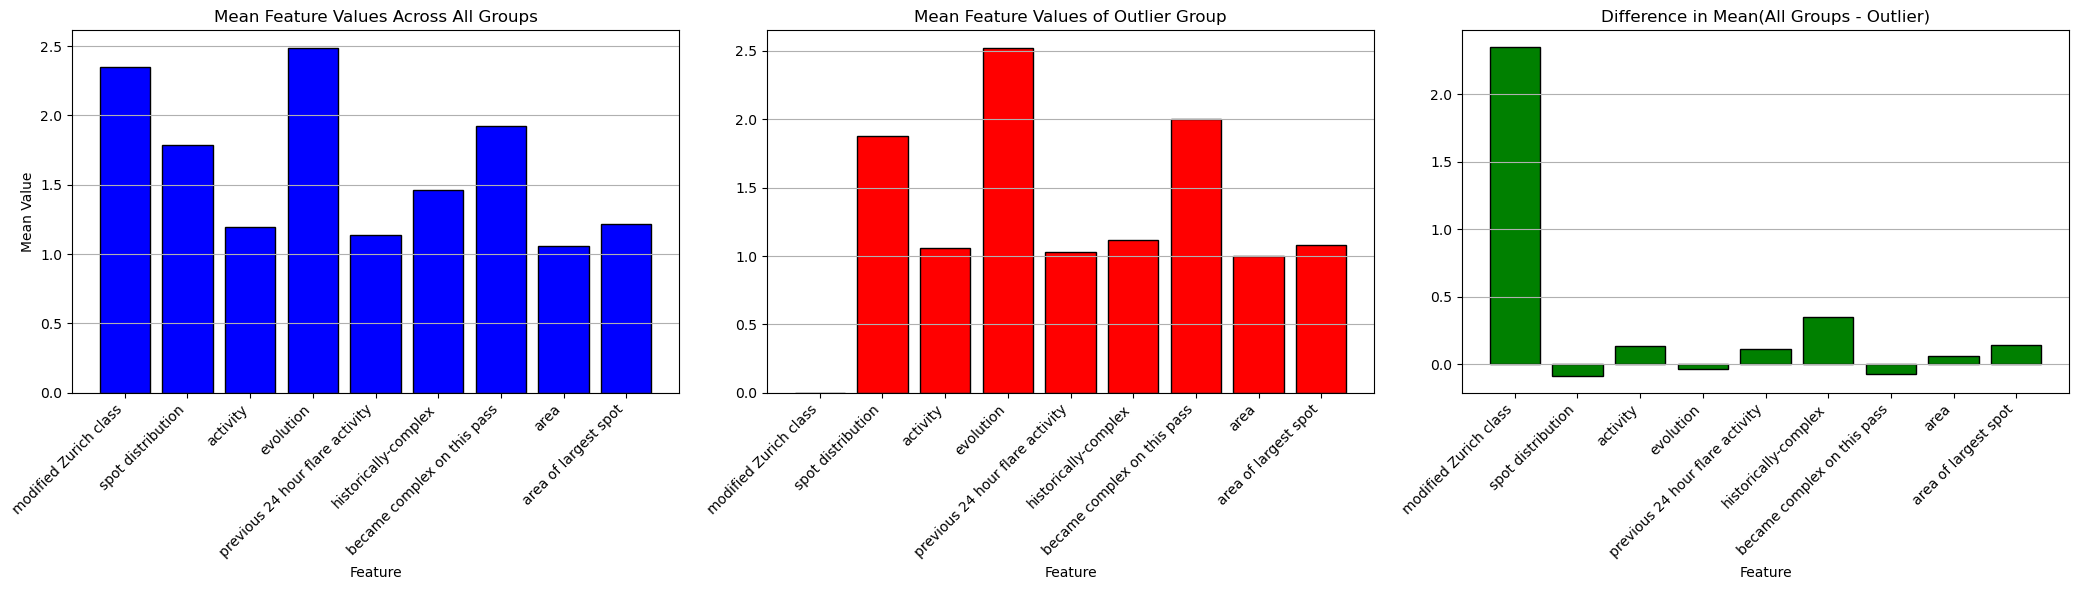

In [113]:
import matplotlib.pyplot as plt 
mean_all_groups = np.mean([np.mean(group, axis=0) for i, group in enumerate(datasets) if i != 8], axis=0)

# Compute mean feature values for the outlier group
mean_outlier_group = np.mean(datasets[5], axis=0)

# Compute the delta between the two (outlier vs all groups)
difference_values =  mean_all_groups - mean_outlier_group

percentage_change = ((mean_outlier_group - mean_all_groups) / mean_all_groups) * 100

# Feature names for labeling
num_features = len(mean_all_groups)
x_labels = feature_names[:num_features]  # Adjust based on the number of features

# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(21, 6), sharey=False)

# Mean feature values for all groups (excluding outlier)
ax[0].bar(range(num_features), mean_all_groups, color='blue', edgecolor='black')
ax[0].set_xticks(range(num_features))
ax[0].set_xticklabels(x_labels, rotation=45, ha='right')
ax[0].set_title('Mean Feature Values Across All Groups')
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Mean Value')
ax[0].grid(axis='y')

# Mean feature values for the outlier group
ax[1].bar(range(num_features), mean_outlier_group, color='red', edgecolor='black')
ax[1].set_xticks(range(num_features))
ax[1].set_xticklabels(x_labels, rotation=45, ha='right')
ax[1].set_title('Mean Feature Values of Outlier Group')
ax[1].set_xlabel('Feature')
ax[1].grid(axis='y')

# Delta values (difference between the outlier group and all groups)
ax[2].bar(range(num_features), difference_values, color='green', edgecolor='black')
ax[2].set_xticks(range(num_features))
ax[2].set_xticklabels(x_labels, rotation=45, ha='right')
ax[2].set_title('Difference in Mean(All Groups - Outlier)')
ax[2].set_xlabel('Feature')
ax[2].grid(axis='y')

# ax[3].bar(range(num_features), percentage_change, color='purple', edgecolor='black')
# ax[3].set_xticks(range(num_features))
# ax[3].set_xticklabels(x_labels, rotation=45, ha='right')
# ax[3].set_title('Percentage Change (Outlier - All Groups)')
# ax[3].set_xlabel('Feature')
# ax[3].grid(axis='y')

# fig, ax2 = plt.subplots(figsize=(14, 6))  # New figure for the percentage change plot
# ax2.bar(range(num_features), percentage_change, color='purple', edgecolor='black')
# ax2.set_xticks(range(num_features))
# ax2.set_xticklabels(x_labels, rotation=45, ha='right')
# ax2.set_title('Percentage Change (Outlier - All Groups)')
# ax2.set_xlabel('Feature')
# ax2.grid(axis='y')

plt.tight_layout()
plt.show()

In [277]:
X_scaled_df = pd.DataFrame(X, columns=X.columns)

grouped_data = []

for i, (_, group) in enumerate(X_scaled_df.groupby('largest spot size')):
    group_data = group.drop(columns=['largest spot size']).to_numpy()
    artificial_feature = np.ones((group_data.shape[0],1))  # Default value = 1
    if i == 0:  # and group has anomolous a_f
        artificial_feature.fill(3)
    
    group_data = np.hstack((group_data, artificial_feature))  # Append feature
    grouped_data.append(group_data)

In [278]:
feature_names.append('artificial_feature')

In [279]:
feature_names

['modified Zurich class',
 'spot distribution',
 'activity',
 'evolution',
 'previous 24 hour flare activity',
 'historically-complex',
 'became complex on this pass',
 'area',
 'area of largest spot',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature',
 'artificial_feature']

In [280]:
datasets = grouped_data

In [281]:
datasets

[array([[2., 2., 1., ..., 1., 2., 3.],
        [2., 2., 1., ..., 1., 2., 3.],
        [2., 2., 1., ..., 1., 1., 3.],
        ...,
        [3., 1., 1., ..., 1., 1., 3.],
        [3., 2., 1., ..., 1., 1., 3.],
        [3., 1., 2., ..., 1., 1., 3.]]),
 array([[1., 1., 1., 3., 1., 1., 2., 1., 2., 1.],
        [5., 3., 1., 2., 1., 2., 2., 1., 1., 1.],
        [5., 3., 1., 3., 1., 1., 2., 1., 2., 1.],
        [2., 2., 1., 2., 1., 1., 2., 1., 2., 1.],
        [1., 1., 2., 3., 1., 1., 2., 1., 2., 1.],
        [1., 1., 2., 2., 3., 1., 2., 1., 2., 1.],
        [2., 1., 1., 3., 1., 1., 2., 1., 2., 1.],
        [2., 1., 2., 3., 3., 2., 2., 1., 2., 1.],
        [1., 1., 1., 2., 1., 2., 2., 1., 2., 1.],
        [1., 2., 1., 2., 1., 2., 2., 1., 2., 1.],
        [5., 3., 1., 3., 1., 1., 2., 1., 2., 1.],
        [5., 3., 1., 2., 1., 1., 1., 1., 1., 1.],
        [5., 3., 1., 3., 1., 1., 1., 1., 1., 1.],
        [1., 2., 1., 3., 1., 1., 2., 1., 1., 1.],
        [5., 3., 1., 3., 1., 1., 2., 1., 1., 1.],
 

In [282]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier

In [300]:
classifier = OneClassSMMClassifier(nu=0.38)

In [301]:
classifier.fit(datasets)

In [302]:
decision, y_pred = classifier.predict(datasets)

In [303]:
y_pred

array([-1.,  1., -1.,  1., -1., -1.])

In [304]:
decision

array([-2.04473493e-08,  6.10191183e-02, -1.69141613e-08,  8.88321538e-02,
       -1.73225695e-08, -1.30854976e-07])

In [305]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[0, 2, 4, 5]

In [41]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

divide by zero encountered in log2
invalid value encountered in cast
invalid value encountered in log2
100%|██████████| 1023/1023 [01:35<00:00, 10.70it/s]


In [42]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [43]:
shapley_values

tensor([[-4.5299e-02,  2.4349e-02, -5.7860e-03,  5.2722e-02,  1.2430e-02,
         -3.7805e-02],
        [-6.1697e-02,  1.9637e-02,  3.9804e-03,  2.5492e-02,  3.3645e-02,
         -2.0893e-02],
        [-1.5770e-02,  2.8457e-03, -3.7138e-03,  9.1324e-03,  2.8681e-03,
          4.5100e-03],
        [-1.4216e-02,  1.3853e-02, -3.2537e-04,  5.2907e-03, -2.5707e-03,
         -2.4396e-03],
        [-1.0417e-02,  3.6658e-03,  4.2501e-03,  1.3195e-03,  7.0984e-04,
          5.1723e-04],
        [-2.1985e-02,  5.3924e-03, -4.6311e-03,  1.2629e-02,  7.0984e-04,
          8.0064e-03],
        [-7.3092e-03,  7.1622e-03, -5.6131e-03, -7.5241e-04,  2.0177e-02,
         -1.3857e-02],
        [-7.6545e-03, -3.4133e-03,  7.1746e-03,  1.5785e-03,  1.3573e-03,
          9.2730e-04],
        [-1.9740e-02,  1.6658e-02,  8.7497e-03,  5.4252e-04, -6.7134e-05,
         -6.1946e-03],
        [-9.3980e-02,  3.3060e-02,  2.0652e-02,  1.5175e-02,  1.3141e-02,
          1.2085e-02]])

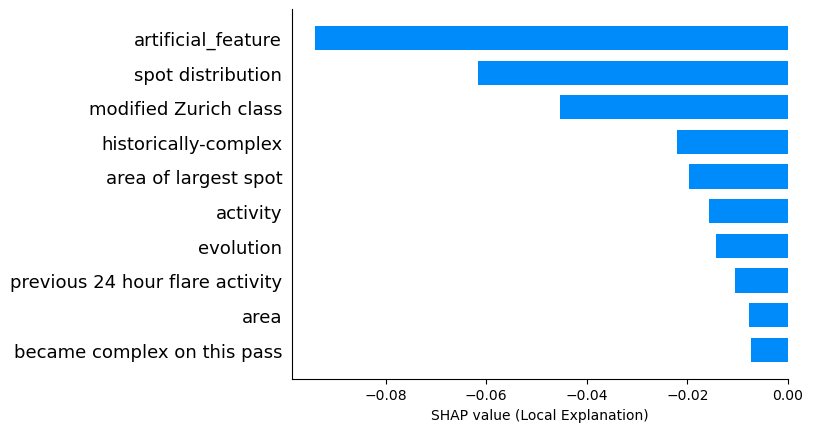

In [44]:
from src.utils.visualisation.deterministic_values import global_bar_plot, bar_plot
bar_plot(shapley_values.T[0], feature_names=feature_names)

artificial feature is the highest contribution towars making this group an outlier.

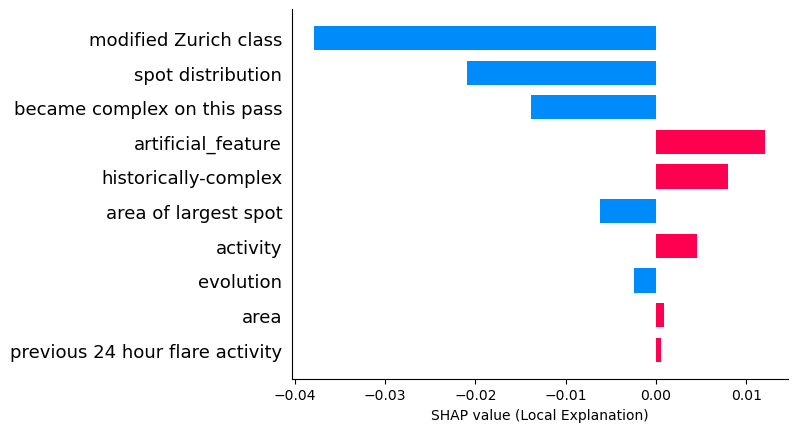

In [45]:
bar_plot(shapley_values.T[5], feature_names=feature_names)

For the other outlier, it is caused due to other reasons(similar to first part) and not artificial_feature.

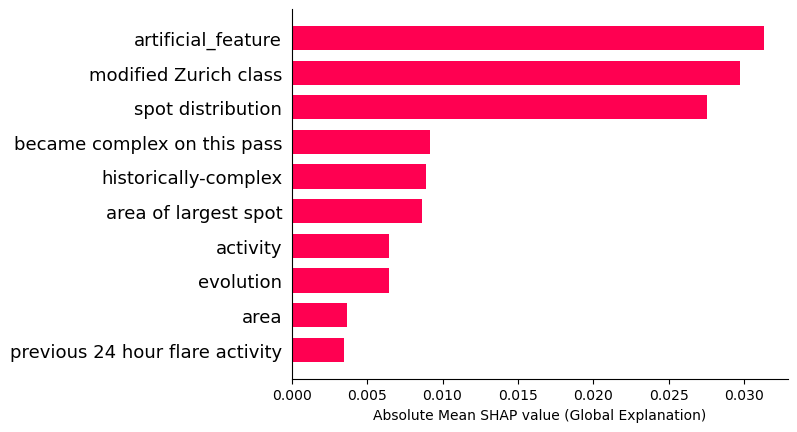

In [46]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot(mean_abs_shap_values, feature_names=feature_names)

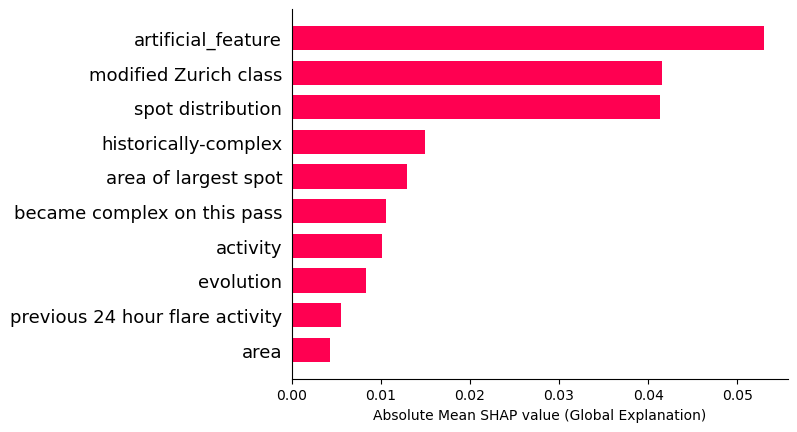

In [47]:
selected_shap_values = shapley_values[:,outlier_indices]
mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1) 
global_bar_plot(mean_abs_shap_values_outlier, feature_names=feature_names)